# Rainfall anomalies averaged over polygons

## Load packages, connect to datacube

In [1]:
%matplotlib inline

import datacube
import gc
import matplotlib.pyplot as plt
import geopandas as gpd
from datacube.utils import geometry
import pandas as pd
import matplotlib as mpl
import xarray as xr
from odc.algo import xr_reproject
from datacube.utils.geometry import assign_crs

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.dask import create_local_dask_cluster

dc = datacube.Datacube(app="WOfS-figure")

import warnings
warnings.filterwarnings("ignore", message="Iteration over multi-part geometries is deprecated and will be removed in ")

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:40197 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 31 Memory: 254.70 GB


## Analysis parameters

* `year`: The year the anomaly will be calculated for ie, if '2020' then the rainfall for 2020 will be subtracted from the long-term mean
* `vector_file`: The shapefile (geojson) over which the anomalies are iterated. The final results are appended to this dataframe on this file
* `attribute_col`: the column in the "vector_file" that is used to label the results. ie if this is a shapefile with Africam country boundary then the attribute_col should be the column containg the country names
* `output_suffix`: a filename suffix added to the exported results geojson to identify what the results refer to. ie. if iterating over African countries then make this parameter something like 'countries'. 

In [3]:
year='2020'
vector_file = "data/african_countries.shp"
output_suffix = 'countries'

## Open vector file and set-up ODC query

In [4]:
gdf = gpd.read_file(vector_file)
gdf.head()

,name,geometry
0,Sudan,"MULTIPOLYGON (((38.58148 18.02542, 38.58203 18..."
1,Angola,"MULTIPOLYGON (((11.79481 -16.81925, 11.79375 -..."
2,Benin,"MULTIPOLYGON (((1.86343 6.28872, 1.86292 6.288..."
3,Botswana,"POLYGON ((25.17447 -17.77881, 25.18476 -17.783..."
4,Burkina Faso,"POLYGON ((-0.45567 15.08082, -0.45411 15.07937..."


In [5]:
attribute_col = 'name'

resolution = (-5000, 5000) # native CHIRPS resolution
output_crs = 'EPSG:6933'
measurements = ['rainfall']

query = {'measurements': measurements,
         'resolution': resolution,
         'output_crs': output_crs,
         'dask_chunks':dict(x=1000,y=1000)
         }

In [6]:
year_rain = {}
rain_mean = {}
rain_std = {}
rain_anomaly = {}
rain_min = {}
rain_idxmin = {}
rain_max = {}
rain_idxmax = {}

In [ ]:
#try to remove garbage collection warnings
g0, g1, g2 = gc.get_threshold()
gc.set_threshold(g0*3, g1*3, g2*3)

i = 0

# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():
    print(" Feature {:02}/{:02}\r".format(i + 1, len(gdf)),
                  end='')
    
    #skip come countries as no-data
    country=str(row[attribute_col])
    if (country == 'Cape Verde') | (country == 'Mauritius'):
        pass
    
    else:
        # Get the geometry
        geom = geometry.Geometry(row.geometry.__geo_interface__,
                                 geometry.CRS(f'EPSG:{gdf.crs.to_epsg()}'))

        # Update dc query with geometry      
        query.update({'geopolygon': geom}) 

        ds_all = dc.load(product=['rainfall_chirps_monthly'],
                         time=('1981', '2020'),
                         **query).rainfall

        #select out difeent components of calcs
        ds = ds_all.sel(time=year)
        ds_clim=ds_all.sel(time=slice('1981','2010'))
        ds_match_wofs=ds_all.sel(time=slice('2000','2020'))

        # set -9999 no-data values to NaN
        ds = ds.where(ds !=-9999.)
        ds_clim = ds_clim.where(ds_clim !=-9999.)
        ds_match_wofs = ds_match_wofs.where(ds_match_wofs !=-9999.)

        # Generate a polygon mask to keep only data within the polygon
        mask = xr_rasterize(gdf.iloc[[index]], ds)
        ds = ds.where(mask)
        ds_clim = ds_clim.where(mask)
        ds_match_wofs = ds_match_wofs.where(mask)

        # find sum over 12 months (ie total for that year)
        ds = ds.sum(dim='time').mean(dim=['x','y']).compute()

        # Climatologies 
        ds_clim_mean_year = ds_clim.groupby('time.year').sum(dim=['time']).mean(dim=['x','y']).compute()
        ds_clim_std = ds_clim_mean_year.std('year')
        ds_clim_mean = ds_clim_mean_year.mean('year')

        #extra summary stats to match wofs summary plots
        ds_match_wofs_mean_year = ds_match_wofs.groupby('time.year').sum(dim=['time']).mean(dim=['x','y']).compute()
        ds_max = ds_match_wofs_mean_year.max('year')
        ds_idxmax = int(ds_match_wofs_mean_year.idxmax('year').values)
        ds_min = ds_match_wofs_mean_year.min('year')
        ds_idxmin = int(ds_match_wofs_mean_year.idxmin('year').values)
        
        #save annual rainfall time-series for reference
        plt.ioff()
        fig, ax = plt.subplots(1,1, figsize=(11, 5))
        ds_match_wofs_mean_year.plot(ax=ax, marker='o', color='#9467bd')
        plt.title(f'Total annual rainfall: '+country+', 2000 to 2020')
        plt.xlabel('Year')
        plt.ylabel('Total Rainfall (mm)')
        plt.tight_layout()
        fig.savefig('results/pngs/rainfall/rainfall_'+country+'_2000_2020.png', 
                    bbox_inches='tight',
                    dpi=200, 
                    facecolor="white")
        plt.close(fig)

        #anomalies
        anomalies = xr.apply_ufunc(
            lambda x, m, s: (x - m) / s,
            ds,
            ds_clim_mean,
            ds_clim_std,
            output_dtypes=[ds.dtype],
            dask="allowed"
        )

        #ad results to dict
        year_rain.update({country: ds.values.item()})
        rain_mean.update({country: ds_clim_mean.values.item()})
        rain_std.update({country: ds_clim_std.values.item()})
        rain_anomaly.update({country: anomalies.values.item()})
        rain_max.update({country: ds_max.item()})
        rain_min.update({country: ds_min.item()})
        rain_idxmin.update({country: ds_idxmin})
        rain_idxmax.update({country: ds_idxmax}) 

    # Update counter
    i += 1

## Join results onto geodataframe and export

In [8]:
df_rain = pd.DataFrame.from_dict(
    [
        year_rain,
        rain_mean,
        rain_std,
        rain_anomaly,
        rain_max,
        rain_min,
        rain_idxmin,
        rain_idxmax
    ]
).T.rename(
    {
        0: "Total Rainfall " + year + " (mm)",
        1: "Mean Yearly Rainfall 1981-2010 (mm)",
        2: "Std. Dev. Yearly Rainfall 1981-2010 (mm)",
        3: "Standardised Yearly Rainfall Anomaly "+year,
        4: "Max Rainfall 2000-2020 (mm)",
        5: "Min Rainfall 2000-2020 (mm)",
        6: "Year of Min Rainfall 2000-2020",
        7: "Year of Max Rainfall 2000-2020",
    },
    axis=1,
)

df_rain.head()

,Total Rainfall 2020 (mm),Mean Yearly Rainfall 1981-2010 (mm),Std. Dev. Yearly Rainfall 1981-2010 (mm),Standardised Yearly Rainfall Anomaly 2020,Max Rainfall 2000-2020 (mm),Min Rainfall 2000-2020 (mm),Year of Min Rainfall 2000-2020,Year of Max Rainfall 2000-2020
Sudan,173.611008,154.269455,24.961967,0.774841,198.974548,125.073601,2004.0,2019.0
Angola,582.206299,607.468079,36.304028,-0.695840,684.010254,550.185547,2015.0,2011.0
Benin,557.501038,526.110596,59.082329,0.531300,615.347717,464.490143,2013.0,2003.0
Botswana,282.955322,219.209778,53.111511,1.200221,356.188141,143.706665,2015.0,2006.0
Burkina Faso,439.910217,372.965698,38.857849,1.722806,442.781311,343.814087,2004.0,2019.0


## Join results onto geodataframe and export

In [16]:
gdf = gdf.join(df_rain, attribute_col)


In [17]:
# Export results (overwritng WOfS file exported earlier with new rainfall data appended)
gdf.to_file('results/geojsons/rainfall_anomalies_africa_'+output_suffix+'_'+year+'.geojson')

## Explore results

You can read in the geojson if returning to this notebook by uncommenting the cell directly below.

The geodataframe is 'simplified' to speed up processing.

Change the `col_to_plot` parameter to change which variable is plotted


In [ ]:
# gdf = gdf.read_file('results/geojsons/rainfall_anomalies_africa_'+output_suffix+'_'+year+'.geojson')

In [18]:
#simplify so plotting is fast
gdf_simple = gdf.to_crs('epsg:6933')
gdf_simple['geometry'] = gdf_simple['geometry'].simplify(2500)


In [19]:
gdf_simple.columns

Index(['name', 'geometry', 'Total Rainfall 2020 (mm)',
       'Mean Yearly Rainfall 1981-2010 (mm)',
       'Std. Dev. Yearly Rainfall 1981-2010 (mm)',
       'Standardised Yearly Rainfall Anomaly 2020',
       'Max Rainfall 2000-2020 (mm)', 'Min Rainfall 2000-2020 (mm)',
       'Year of Min Rainfall 2000-2020', 'Year of Max Rainfall 2000-2020'],
      dtype='object')

In [21]:
col_to_plot = "Standardised Yearly Rainfall Anomaly "+year

gdf_simple.explore(
    column=col_to_plot,
    cmap="RdBu",
    vmin=-2.5,
    vmax=2.5,
    style_kwds={"fillOpacity": 1.0},
    tiles="CartoDB positron",
)

# ------FIGURES CODE ----------------------------------------------

### Plot rainfall with country boundaries
**Use this section to edit existing plot title, bounds, etc.**

If you have successfully exported the previous shapefile but started a new instance, there is no need to re-process the data. It can be read in from the shapefile by uncommenting and running the code below. Be sure the vector file path is to the correct shapefile title.

In [ ]:
# gdf = gdf.read_file('results/geojsons/rainfall_anomalies_africa_'+output_suffix+'_'+year+'.geojson')

### Customise the plot

In [22]:
col_to_plot = "Standardised Yearly Rainfall Anomaly 2020"

<AxesSubplot:>

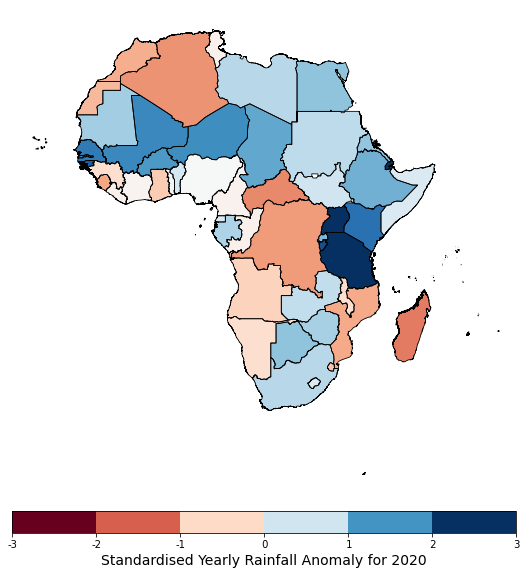

In [35]:
plt.ion() #turn back on interactive plotting

# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(10,10))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])


# Define colour map
cmap = mpl.cm.RdBu
bounds = list(range(-3, 4, 1))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
# cbar.set_ticks([])
cbar.set_ticks([i for i in range(-3, 4, 1)])
cbar.set_ticklabels(list('{:2}'.format(i) for i in (list(range(-3, 4, 1)))))
cbar.set_label("Standardised Yearly Rainfall Anomaly for 2020", fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plot 'pc_change' and 'geometry' boundary lines
gdf.plot(col_to_plot, ax=ax, cmap=cmap,vmin=-3, vmax=3)
gdf.geometry.plot(ax=ax, linewidth=0.8, edgecolor='black', facecolor="none")

# Export figure
fig.savefig('results/pngs/rainfall/rainfall_anomalies_'+year+'_from_1981-2010 mean.png', 
            bbox_inches='tight',
            dpi=200, 
            facecolor="white")

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')